In [1]:
import numpy as np

import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.model_selection import cross_val_score
import xgboost
from sklearn import svm, tree
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from seaborn import heatmap # we going to use heatmap from seaborn module to get also a picture of our matrices



In [2]:
digits = load_digits()

In [3]:
# Print to show there are 1797 images (8 by 8 images for a dimensionality of 64)
print("Image Data Shape" , digits.data.shape)

# Print to show there are 1797 labels (integers from 0-9)
print("Label Data Shape", digits.target.shape)

Image Data Shape (1797, 64)
Label Data Shape (1797,)


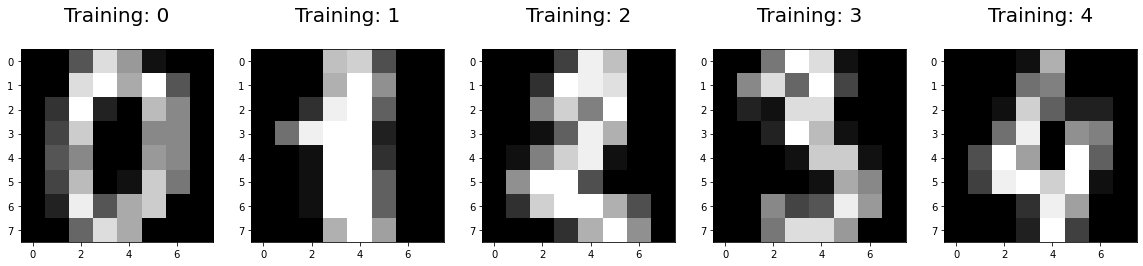

In [4]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(digits.data[0:5], digits.target[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)

    
    plt.title('Training: %i\n' % label, fontsize = 20)

In [5]:
#declare our dependent and independent variable

X = digits.data
y = digits.target

### To be able to choose two of the best algorithms we need to first divide the data and then create a model with it

# Split the data into training, development and test set

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.40,random_state=42 )
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size = 0.50)

In [7]:
#check the portion using our traditional percentage method
X_train.size/X.size,  X_test.size/X.size, X_dev.size/X.size

(0.5998887033945465, 0.2003338898163606, 0.19977740678909292)

In [8]:
y_train

array([7, 6, 0, ..., 2, 7, 1])

# We work with various algorithms first and make a choice after on which one to continue with.

### In this case we will create 6 models 

In [9]:
# create a list and append 6  different models to it

classifiers = []

model1 = xgboost.XGBClassifier(random_state=42)
classifiers.append(model1)
model2 = svm.SVC(gamma='auto',random_state=42)
classifiers.append(model2)
model3 = tree.DecisionTreeClassifier(random_state=42)
classifiers.append(model3)
model4 = RandomForestClassifier(n_estimators=100, random_state=42)
classifiers.append(model4)
model5 = AdaBoostClassifier(n_estimators=50,random_state=42)
classifiers.append(model5)
model6 = GradientBoostingClassifier(n_estimators = 100,random_state=42)
classifiers.append(model6)


#loop through the list get the model fit the training data to it and try it with the development set
for i,clff in enumerate(classifiers):
    
    clff.fit(X_train, y_train)
    
    print("Accuracy",i+1,':',metrics.accuracy_score(y_dev, clff.predict(X_dev)))

Accuracy 1 : 0.958217270194986
Accuracy 2 : 0.4763231197771588
Accuracy 3 : 0.8690807799442897
Accuracy 4 : 0.9665738161559888
Accuracy 5 : 0.32590529247910865
Accuracy 6 : 0.9665738161559888


### From the accuracy we can see that the 4th and 6th perform well on data they've never seen before

## Model 4 is using RandomForestClassifier and 6th model is using GradientBoostingClassifier

In [10]:
for i in enumerate([model4, model6]):
    clff = i[1]
    #clff.fit(X_train, y_train)
    prediction_ = clff.predict(X_dev)
    print("Accuracy",i[0]+1,':',metrics.accuracy_score(y_dev, prediction_))

Accuracy 1 : 0.9665738161559888
Accuracy 2 : 0.9665738161559888


##### We now need to set the parameter for our algorithms: RandomForestClassifier and GradientBoostingClassier are the algorithms we will use based on their performance as stated above

# Parameter to tune

* For each of the models (4th and 6th) we are going to work with n_estimator. 
* that is because n_estimators represents the number of trees in the forest.
* That means that the higher the number of trees the better the learning process.


# Value set for the parameter for testing on the test data

* pre-testing was done on the model ranging between 1 and 100 where n_estimator is equal to i which represent numbers ranging from 1 too 100.
* Some values were the model performs well were picked.
* We make use of GridsearchCV for making a good combination of the best value for each parameter

In [11]:
# creating a dict with parameter and values
param_grid = { 
    'n_estimators': [ 200, 300, 400],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10,15,20],
    'criterion' :['gini', 'entropy']
}

In [12]:

CV_rfc = GridSearchCV(estimator=model4, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_ # this function returns the best combination 

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 300}

In [13]:
param_grid2 = { 
    'n_estimators': [ 200, 300, 400],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10,15,20],
    
}
CV_rfc = GridSearchCV(estimator=model6, param_grid=param_grid2, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}

In [14]:

model4_best = RandomForestClassifier(criterion = 'gini',
                                 max_depth = 15,
                                 max_features = 'log2',
                                 n_estimators = 300,
                                 random_state = 1)
model4_best.fit(X_train, y_train)
pred4_best = model4_best.predict(X_dev)


model6_best = GradientBoostingClassifier(max_depth = 20, max_features = 'log2', n_estimators = 200,random_state=1)
model6_best.fit(X_train, y_train)
pred6_best = model6_best.predict(X_dev)

print(metrics.accuracy_score(y_dev, pred4_best),metrics.accuracy_score(y_dev, pred6_best))

0.9693593314763231 0.9721448467966574


# print confusion matrices for the two models's predictions on the test set

[[36  0  0  0  0  0  0  0  0  0]
 [ 0 32  1  0  0  0  0  0  0  0]
 [ 0  0 36  0  0  0  0  0  0  0]
 [ 0  0  0 31  0  1  0  0  2  0]
 [ 0  0  0  0 37  0  0  0  0  0]
 [ 0  0  0  0  1 34  1  0  0  0]
 [ 0  0  0  0  0  1 36  0  0  0]
 [ 0  0  0  0  0  0  0 33  0  1]
 [ 0  3  0  0  0  0  0  0 37  0]
 [ 0  0  0  0  0  0  0  0  0 36]] 0.9693593314763231


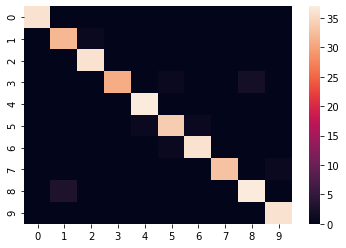

In [15]:

matrix_ = metrics.confusion_matrix(y_dev, pred4_best)
heatmap(matrix_)
print(matrix_, metrics.accuracy_score(y_dev, pred4_best))

[[36  0  0  0  0  0  0  0  0  0]
 [ 0 33  0  0  0  0  0  0  0  0]
 [ 0  0 36  0  0  0  0  0  0  0]
 [ 0  0  0 32  0  1  0  0  1  0]
 [ 0  0  0  0 37  0  0  0  0  0]
 [ 0  1  0  0  0 33  1  0  0  1]
 [ 0  0  0  0  0  1 36  0  0  0]
 [ 0  0  0  0  0  0  0 33  0  1]
 [ 0  2  0  0  0  1  0  0 37  0]
 [ 0  0  0  0  0  0  0  0  0 36]] 0.9721448467966574


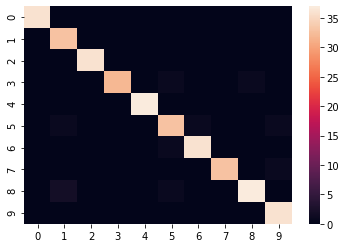

In [16]:
matrix_ = metrics.confusion_matrix(y_dev, pred6_best)
heatmap(matrix_)
print(matrix_, metrics.accuracy_score(y_dev, pred6_best))

## Report about which classes the models struggle with the most.



#### our report will be visually.

* We are going to count the total for the accuracies of each class in the dev set
* We will do the same for the predicted set
* We then plot the results to see the distance between the class in the development set and those predicted


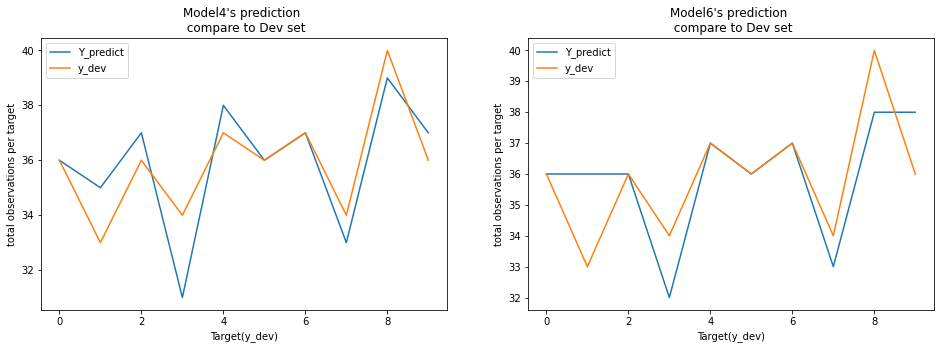

In [17]:
import pandas as pd
plt.figure(figsize=(16,5)) #set a nice and big enough canvas


# what is happening in the loop is i=ax or for graph position, pre=predicted classes for the two models and titl=title of models
for i, pre,  titl in zip(range(2),[pred4_best, pred6_best], ['Model4\'s prediction \n compare to Dev set', 'Model6\'s prediction \n compare to Dev set']):
    
    ax = plt.subplot(1,2,i+1) # set the position of the graph 
    
    #ref line 7-10 
    pd.DataFrame(pre)[0].value_counts().sort_index().plot(ax=ax, label='Y_predict')
    pd.DataFrame(y_dev)[0].value_counts().sort_index().plot(ax=ax,label='y_dev')
    plt.title(titl)
    plt.legend()
    plt.xlabel('Target(y_dev)')
    plt.ylabel('total observations per target')
    
    

 # looking at the graphs above we can see a good harmony and flow between the predicted data and the real data
 
   
* looking closely one can point out that the distance between the data at index 3 is a bit bigger than the other
* both models stuggled a bit to catch the four last points.

## Report the accuracy, precision, recall and f1-score

In [19]:
accu_4 = metrics.accuracy_score(y_dev, pred4_best)
preci_4 = metrics.precision_score(y_dev, pred4_best,average='micro') # will return the total ratio of tp/(tp + fp)
recall_4 = metrics.recall_score(y_dev, pred4_best,average='micro') 
f1_4 = metrics.f1_score(y_dev, pred4_best,average='micro')


print(f"MODEL 4 SCORE REPORTs \n \nAccuracy:{accu_4} \nPrecision:{preci_4} \nRecall:{recall_4} \nF1_score:{f1_4}")

MODEL 4 SCORE REPORTs 
 
Accuracy:0.9693593314763231 
Precision:0.9693593314763231 
Recall:0.9693593314763231 
F1_score:0.9693593314763231


In [20]:
accu_6 = metrics.accuracy_score(y_dev, pred6_best)
preci_6 = metrics.precision_score(y_dev, pred6_best,average='micro')  #will return the total ratio of tp/(tp + fp)
recall_6 = metrics.recall_score(y_dev, pred6_best,average='micro') 
f1_6 = metrics.f1_score(y_dev, pred6_best,average='micro')


print(f"MODEL 6 SCORE REPORTs \n \nAccuracy:{accu_6} \nPrecision:{preci_6} \nRecall:{recall_6} \nF1_score:{f1_6}")

MODEL 6 SCORE REPORTs 
 
Accuracy:0.9721448467966574 
Precision:0.9721448467966574 
Recall:0.9721448467966574 
F1_score:0.9721448467966572


* The differences in performance and report which model did the best jobs


#  Model 6 took more time and thus has given us the best results as compared to model 4 which took less time. 
